# 4.Modeling

### 4.1.Import Libaries

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.model_selection import cross_validate,cross_val_score, train_test_split, GridSearchCV, learning_curve
from sklearn.decomposition import PCA
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error,accuracy_score, recall_score, precision_score, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import datetime


### 4.2.Load Data( Test set and training set )

In [2]:
datafilepath = "../data/interim/train_test_split.pkl"

with open(datafilepath, 'rb') as file:
    X,y,X_train, X_test, y_train, y_test = pickle.load(file)

### Initiation

In [3]:
#Calculate the mean of `y_train`
#train_mean = y_train.mean()
#train_mean

In [4]:
#Calculate the medium of `y_train`
X_defaults_median = X_train.median()
X_defaults_median

VICT_AGE               0.014157
latitude               0.014358
longitude             -0.020706
MTH_RPTD              -0.130399
DAY_RPTD               0.019017
YEAR_RPTD             -0.086864
MTH_OCC               -0.132658
DAY_OCC                0.027940
YEAR_OCC              -0.082279
WEEKDAY_OCC_Encoded    0.022243
AREA_NAME_Encoded      0.021094
dtype: float64

##### Impute NaN Data

In [5]:
# handling NaN values
# Replace 'mean' with 'median', 'most_frequent', or a constant value if needed

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train = imputer.fit_transform(X_train)

In [6]:
# Check for NaN values
print("NaN values in X_test:", X_test.isna().sum().sum())

# Replace NaN values with the mean (you can choose other methods)
X_test = X_test.fillna(X_test.mean())

# Check for infinity values
print("Infinity values in X_test:", np.isinf(X_test).sum().sum())

# Replace infinity values
X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(X_test.mean())

NaN values in X_test: 0
Infinity values in X_test: 0


In [7]:
# Normalize or Scale your data
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)
X_test_scaled

array([[ 0.01447232,  0.16498082, -0.06829201, ..., -1.34682972,
         0.51540649,  1.50343   ],
       [-1.27710816,  0.04991665, -0.05669428, ...,  0.92790868,
        -0.96973575,  1.3387435 ],
       [ 0.05900958, -0.08445359, -0.0170105 , ...,  1.68615482,
         1.01045391, -1.6256135 ],
       ...,
       [-0.29728848,  0.14480598, -0.06826406, ...,  1.4334061 ,
         0.02035908,  1.50343   ],
       [-0.11913945, -0.04893042, -0.01455123, ...,  0.67515997,
         1.01045391, -1.6256135 ],
       [-0.34182574,  0.04518666, -0.02463985, ..., -1.59957843,
         0.51540649, -0.6374945 ]])

### 4.3.Models

Lets try different models. </br>
Decision tree-based models with different criteria (Gini impurity and entropy) and Random forest classicification.</br>
Besides , we will do modles evaulation with <b>Cross-Validation to Tune Hyperparameters</b></br>
We will evaluate the models using <b>GridSearchCV</b> for an exhaustive search over specified parameter values.

#### Decision Tree Classifier (gini)

In [8]:
dt_gini_model = DecisionTreeClassifier(criterion='gini')
dt_gini_model.fit(X_train, y_train)
# Making predictions
dt_gini_pred = dt_gini_model.predict(X_test)

<b> Decision Tree Classifier (gini) :Evaluation</b></br>

In [10]:
# Define the parameter grid for the Decision Tree
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a GridSearchCV object
dt_gini_grid_search = GridSearchCV(estimator=DecisionTreeClassifier(criterion='gini'), 
                                   param_grid=param_grid, 
                                   cv=5, 
                                   n_jobs=-1, 
                                   verbose=2)

# Fit the grid search to the data
dt_gini_grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best parameters found: ", dt_gini_grid_search.best_params_)
print("Best cross-validated score: ", dt_gini_grid_search.best_score_)

# Predict on the test set using the best found parameters
dt_gini_best_pred = dt_gini_grid_search.best_estimator_.predict(X_test)

print("Accuracy:", accuracy_score(y_test, dt_gini_best_pred))
print("Recall:", recall_score(y_test, dt_gini_best_pred, average='macro'))
print("Precision:", precision_score(y_test, dt_gini_best_pred, average='macro'))
print("F1 Score:", f1_score(y_test, dt_gini_best_pred, average='macro'))


dt_gini_cof = confusion_matrix(y_test, dt_gini_best_pred)
dt_gini_cof

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters found:  {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best cross-validated score:  0.5055287457658577
Accuracy: 0.5062850620153959
Recall: 0.4772669704823146
Precision: 0.5048952368060493
F1 Score: 0.44327025457617764


array([[28842,  7273, 12694,   578,   502],
       [ 9936, 12016,  9333,   411,  6612],
       [14458,  7299, 18567,   352,   808],
       [13941,  6484, 10857,  2238,  4275],
       [   84,   176,    36,   292, 47447]])

#### Decision Tree Classifier (entropy)

In [11]:
dt_entropy_model = DecisionTreeClassifier(criterion='entropy')
dt_entropy_model.fit(X_train, y_train)
# Making predictions
dt_en_pred = dt_entropy_model.predict(X_test)

<b> Decision Tree Classifier (entropy) :Evaluation</b></br>

In [12]:

# Define the parameter grid for Decision Tree with entropy
param_grid_dt_entropy = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a GridSearchCV object for Decision Tree with entropy
dt_entropy_grid_search = GridSearchCV(estimator=DecisionTreeClassifier(criterion='entropy'), 
                                      param_grid=param_grid_dt_entropy, 
                                      cv=5, 
                                      n_jobs=-1, 
                                      verbose=2)

# Fit the grid search to the data
dt_entropy_grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best parameters found for Decision Tree with entropy: ", dt_entropy_grid_search.best_params_)
print("Best cross-validated score for Decision Tree with entropy: ", dt_entropy_grid_search.best_score_)

# Evaluate the predictions
dt_entropy_best_pred = dt_entropy_grid_search.best_estimator_.predict(X_test)


print("Accuracy:", accuracy_score(y_test, dt_entropy_best_pred))
print("Recall:", recall_score(y_test, dt_entropy_best_pred, average='macro'))
print("Precision:", precision_score(y_test, dt_entropy_best_pred, average='macro'))
print("F1 Score:", f1_score(y_test, dt_entropy_best_pred, average='macro'))


dt_en_cof = confusion_matrix(y_test, dt_entropy_best_pred)
dt_en_cof

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters found for Decision Tree with entropy:  {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5}
Best cross-validated score for Decision Tree with entropy:  0.5061795276321285
Accuracy: 0.504136679798247
Recall: 0.4756796554958266
Precision: 0.509903276960326
F1 Score: 0.44064012889138826


array([[28005,  8173, 12722,   468,   521],
       [10095, 12437,  8704,   295,  6777],
       [13817,  8027, 18530,   281,   829],
       [13476,  7530, 10379,  2052,  4358],
       [   80,    73,    37,   222, 47623]])

#### Random Forest

In [15]:
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)
# Making predictions
rf_pred = rf_model.predict(X_test)

<b> Random Forest:Evaluation</b></br>

In [17]:
# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_features': ['sqrt'], 
    'max_depth': [None, 10],   
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}


# Create a GridSearchCV object for Random Forest
rf_grid_search = GridSearchCV(estimator=RandomForestClassifier(), 
                              param_grid=param_grid_rf, 
                              cv=5, 
                              n_jobs=-1, 
                              verbose=2)

# Fit the grid search to the data
rf_grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best parameters found for Random Forest: ", rf_grid_search.best_params_)
print("Best cross-validated score for Random Forest: ", rf_grid_search.best_score_)

# Evaluate the predictions
rf_best_pred = rf_grid_search.best_estimator_.predict(X_test)


print("Accuracy:", accuracy_score(y_test, rf_best_pred))
print("Recall:", recall_score(y_test, rf_best_pred, average='macro'))
print("Precision:", precision_score(y_test, rf_best_pred, average='macro'))
print("F1 Score:", f1_score(y_test, rf_best_pred, average='macro'))


rf_cof = confusion_matrix(y_test, rf_best_pred)
rf_cof

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 8.5min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 4.2min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=10.2min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=14.7min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 5.5min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 4.0min
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 2.2min
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_es

/Users/thantthiri/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 8.5min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 4.2min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=10.2min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 7.1min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=13.1min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 8.5min
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 2.6min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=12.8min
[CV] END max_depth=None, m

[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=10.2min
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 4.7min
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 3.8min
F1 Score: 0.5222356738817002


array([[32151,  5029,  8697,  3504,   508],
       [ 8410, 13758,  7509,  2451,  6180],
       [12049,  5775, 19819,  3027,   814],
       [12503,  5137,  7996,  8261,  3898],
       [   83,   348,    27,   184, 47393]])

<b>Support Vector Machines with Kernel</b>

In [ ]:
from sklearn.svm import SVC

svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')  # You can adjust kernel type, C, and gamma as needed
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)

In [ ]:
# Define the parameter grid for SVM
param_grid_svm = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'gamma': [1, 0.1, 0.01, 0.001],  # Kernel coefficient
    'kernel': ['rbf', 'poly', 'sigmoid']  # Type of kernel
}

# Create a GridSearchCV object for SVM
svm_grid_search = GridSearchCV(SVC(), param_grid=param_grid_svm, cv=5, verbose=2, n_jobs=-1)

# Fit the grid search to the data
svm_grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best parameters found for SVM: ", svm_grid_search.best_params_)
print("Best cross-validated score for SVM: ", svm_grid_search.best_score_)

# Evaluate the predictions using the best estimator
svm_best_pred = svm_grid_search.best_estimator_.predict(X_test)

# Metrics
print("Accuracy:", accuracy_score(y_test, svm_best_pred))
print("Recall:", recall_score(y_test, svm_best_pred, average='macro'))
print("Precision:", precision_score(y_test, svm_best_pred, average='macro'))
print("F1 Score:", f1_score(y_test, svm_best_pred, average='macro'))

# Confusion Matrix
svm_cof = confusion_matrix(y_test, svm_best_pred)
svm_cof

### 4.4.Comparison on the models

<b>Plotting Confustion Matrix</b>

Confusion matrices are crucial in evaluating the performance of classification models, showing the counts of true positives, false positives, true negatives, and false negatives.

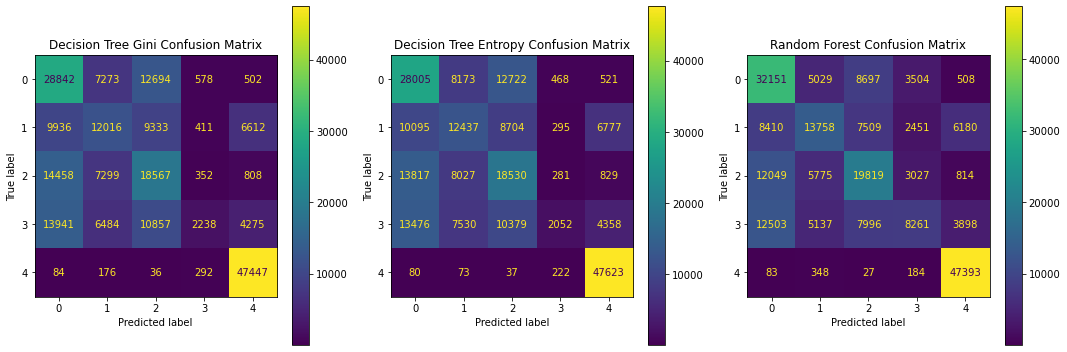

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))  # Adjusted for 3 subplots

ConfusionMatrixDisplay(confusion_matrix=dt_gini_cof).plot(ax=ax[0], values_format='d')
ax[0].set_title('Decision Tree Gini Confusion Matrix')

ConfusionMatrixDisplay(confusion_matrix=dt_en_cof).plot(ax=ax[1], values_format='d')
ax[1].set_title('Decision Tree Entropy Confusion Matrix')

ConfusionMatrixDisplay(confusion_matrix=rf_cof).plot(ax=ax[2], values_format='d')
ax[2].set_title('Random Forest Confusion Matrix')

plt.tight_layout()
plt.show()

Based on these metrics above, the Random Forest model performs slightly better in terms of accuracy, recall, precision, and F1 score compared to the Decision Tree with the Gini criterion and the entropy criterion. <br/>
However,to choose the best model,not only these metrics but also factors such as computational complexity, scalability, and maintenance costs should be considered.Random Forest model typically involves more computational cost due to the ensemble of trees but might generalize better when provided with more data. On the other hand, Decision Trees are simpler and faster but may not perform as well on unseen data.
</br>
Between 2 decision Trees,  The Gini model performs slightly better in terms of accuracy, recall, and F1 score, while the entropy model excels in precision and cross-validated score.A simpler model may be preferable since it performs only slightly worse than a more complex model.The Gini model will be chosen to favour higher recall.

## 4.5.Final Model

<b>Model Interpretation on tree-based model (Gini)</b>

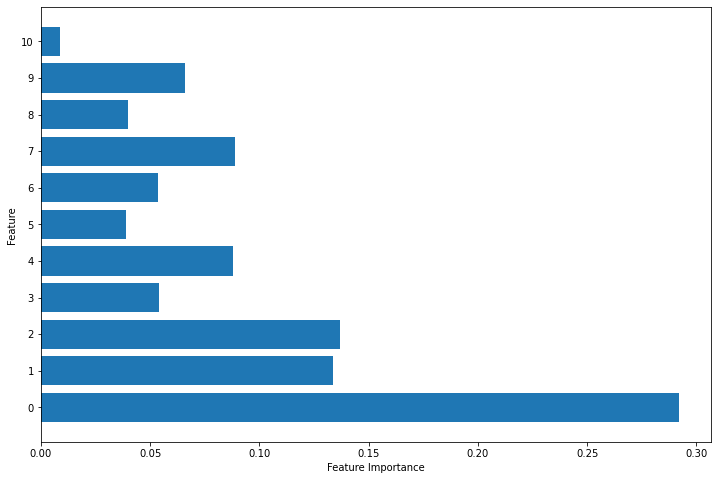

In [29]:
# Assuming X_train is a NumPy array
X_train = pd.DataFrame(X_train)  # Convert to a DataFrame

# Now you can access the columns
features = X_train.columns


# Assume dt_gini_model is your trained Decision Tree model
feature_importance = dt_gini_model.feature_importances_

plt.figure(figsize=(12, 8))
plt.barh(range(len(feature_importance)), feature_importance, align='center')
plt.yticks(range(len(feature_importance)), features)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

<b>Model Validation</b>

Plotting learning curves, which is a great way to check for overfitting or underfitting.

/Users/thantthiri/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


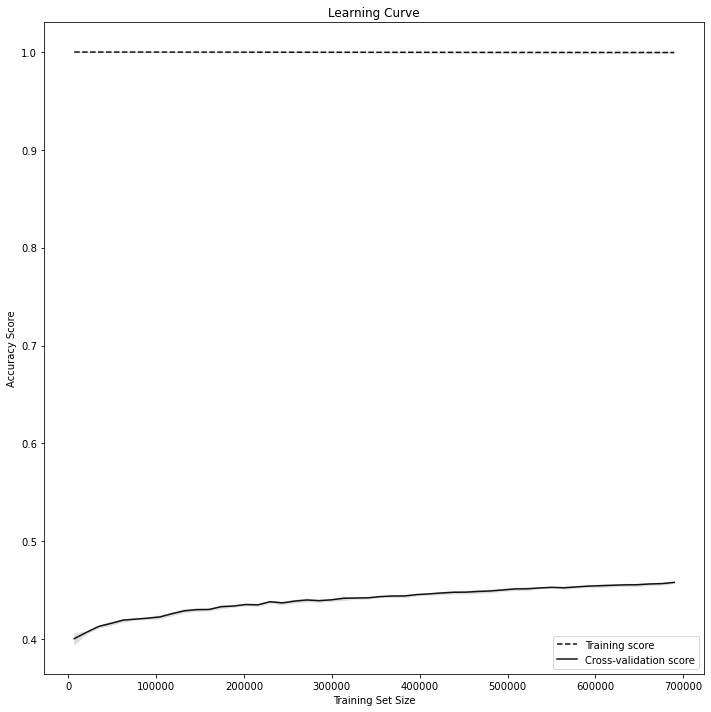

In [30]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    dt_gini_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1, 
    train_sizes=np.linspace(0.01, 1.0, 50))

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curves
plt.subplots(1, figsize=(10,10))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

The training score starts high and remains high, indicating that the model is fitting the training data well.
</br>
The cross-validation score starts low and slightly increases, but there is a large gap between the training and cross-validation scores. This indicates that the model is not generalizing well and is likely overfitting the training data. Overfitting happens when a model learns the details and noise in the training data to the extent that it negatively impacts the performance of the model on new data.
</br>
Ideally, both lines should converge to a point where the training score decreases slightly and the cross-validation score increases to a point of stability. Both scores should be as high as possible.



In [ ]:
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, 1.0]
train_size, train_scores, test_scores = learning_curve(pipe, X_train, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

In [ ]:
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');

<b>Final Model Training</b>

In [ ]:

final_model = RandomForestClassifier(**rf_grid_search.best_params_)
final_model.fit(np.vstack((X_train, X_test)), np.concatenate((y_train, y_test)))


In [ ]:
final_model.version = '1.0'
final_model.pandas_version = pd.__version__
final_model.numpy_version = np.__version__
final_model.sklearn_version = sklearn_version
final_model.X_columns = [col for col in X_train.columns]
final_model.build_datetime = datetime.datetime.now()

In [ ]:
modelpath = '../models'
save_file(best_model, 'top5_crime_cat_model.pkl', modelpath)